1, view 1st dcm file

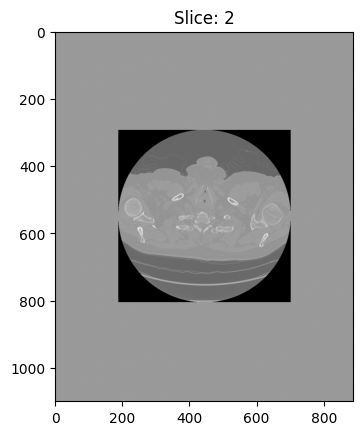

In [3]:
import pydicom
import matplotlib.pyplot as plt

ds = pydicom.dcmread("/Users/angelbuthebest/Desktop/cs3244_project_osic/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/2.dcm")
plt.imshow(ds.pixel_array, cmap='gray')
plt.title(f"Slice: {ds.InstanceNumber}")
plt.show()



image feature extraction
step 1: load and store the dicom stack

In [1]:
import os
# os package as a universal remote control for computer's file system. 
# the same code write to handle files on Windows will also work on a Mac or Linux machine without changes, which is a major benefit.
import pandas as pd
import pydicom
import numpy as np
from tqdm import tqdm # a library for progress bars

# 1, definne file path
base_path = "/Users/angelbuthebest/Desktop/cs3244_project_osic/osic-pulmonary-fibrosis-progression/"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))

# testing
print(f"Train directory: {train_path}")
print(f"Found {len(os.listdir(train_path))} patient folders in the train directory.")
print(f"The first few rows of train.csv:")
display(train_df.head())

Train directory: /Users/angelbuthebest/Desktop/cs3244_project_osic/osic-pulmonary-fibrosis-progression/train
Found 177 patient folders in the train directory.
The first few rows of train.csv:


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [48]:
# implement the DICOM loading function
def load_scan(patient_folder):
    slices = [pydicom.dcmread(os.path.join(patient_folder, s)) for s in os.listdir(patient_folder)]
    # sort slices by InstanceNumber
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

# testing on a single patient
first_patient_id = "ID00019637202178323708467"
first_patient_folder = os.path.join(train_path, first_patient_id)

print(f"\n--- Testing on patient: {first_patient_id} ---")
print(f"Looking in folder: {first_patient_folder}")

# load the slices for the first patient
slices = load_scan(first_patient_folder)

print(f"\nSuccessfully loaded {len(slices)} slices.")
# Let's inspect the first slice's metadata to confirm it's loaded
print("Metadata for the first slice:")
print(slices[0])



--- Testing on patient: ID00019637202178323708467 ---
Looking in folder: /Users/angelbuthebest/Desktop/cs3244_project_osic/osic-pulmonary-fibrosis-progression/train/ID00019637202178323708467

Successfully loaded 29 slices.
Metadata for the first slice:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 200
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 2.25.86619954523342666252534157549509223762
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002,0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002,0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 6'
(0008,0008)

2, HU Conversion and Lung Segmentation

In [49]:
import cv2
import numpy as np
from skimage import measure, morphology
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt

# --- 2.1 Implement HU Conversion Function (Same as before) ---
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# --- 2.2 Definitive Lung Segmentation Function ---
def segment_lung_mask_definitive(image_hu):
    """
    Definitive version:
    1. Create a solid mask of the patient's body.
    2. Find all air within that body mask.
    3. Keep the two largest air regions (the lungs).
    4. Clean up the final mask.
    """
    segmented_mask = np.zeros_like(image_hu, dtype=np.uint8)
    
    for i, slice_img in enumerate(image_hu):
        # Step 1: Create a solid body mask
        # A threshold of -500 HU is common for separating tissue from air
        body_mask = slice_img > -500
        # Fill holes in the body mask to make it solid
        body_mask = binary_fill_holes(body_mask)
        
        # Step 2: Find air inside the body
        # Threshold for air-like HU values
        air_mask = (slice_img > -1000) & (slice_img < -400)
        # Isolate the air that is *only* inside the body
        internal_air_mask = air_mask & body_mask
        
        # Step 3: Keep the two largest components
        labels = measure.label(internal_air_mask)
        props = measure.regionprops(labels)
        
        # for some top/bottom slices to not contain both lungs
        if len(props) < 1:
            continue

        areas = [prop.area for prop in props]
        sorted_labels_by_area = [p.label for p in sorted(props, key=lambda p: p.area, reverse=True)]
        
        lung_mask_slice = np.zeros_like(slice_img, dtype=np.uint8)
        # Add the largest component
        lung_mask_slice[labels == sorted_labels_by_area[0]] = 1
        # If there's a second large one, add it too
        if len(sorted_labels_by_area) > 1:
            lung_mask_slice[labels == sorted_labels_by_area[1]] = 1
            
        # Step 4: Final cleanup with morphological operations
        lung_mask_slice = morphology.binary_closing(lung_mask_slice, footprint=morphology.disk(5))
        
        segmented_mask[i] = lung_mask_slice

    return segmented_mask

--- Applying Preprocessing (Definitive Method) ---
Lung segmentation complete.


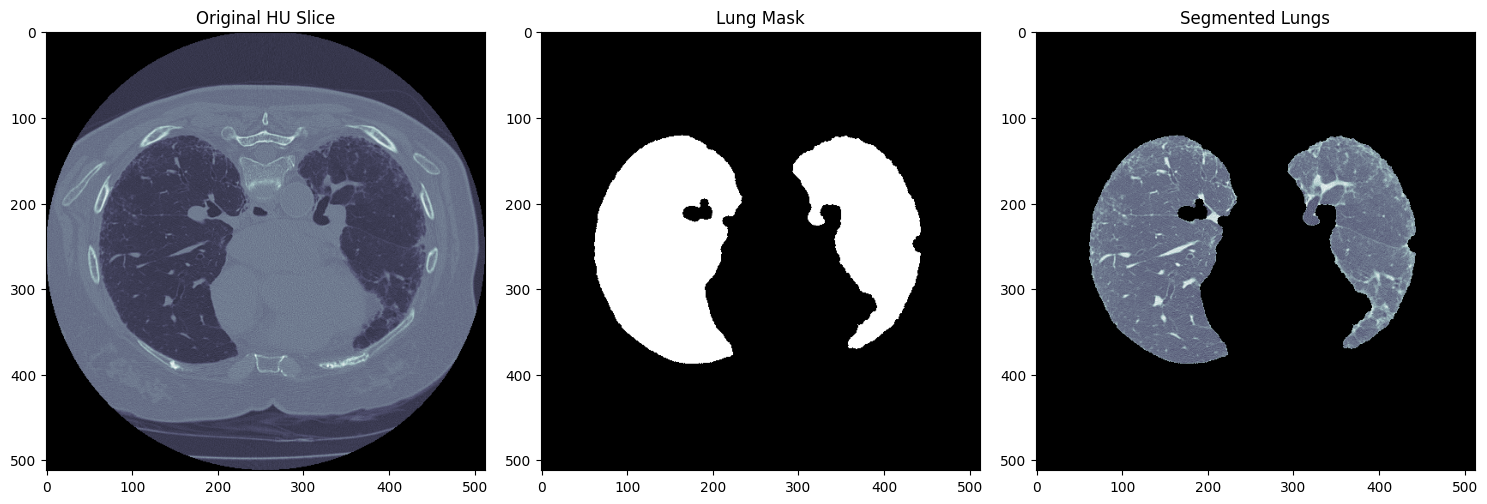

In [50]:
# 2.3 Apply the Functions 
print("--- Applying Preprocessing (Definitive Method) ---")
patient_hu = get_pixels_hu(slices)
lung_mask = segment_lung_mask_definitive(patient_hu)
segmented_lungs_hu = patient_hu.copy()
segmented_lungs_hu[lung_mask == 0] = -2000
print("Lung segmentation complete.")


# 2.4 Visualize a Slice to Verify 
middle_slice_index = len(patient_hu) // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(patient_hu[middle_slice_index], cmap=plt.cm.bone)
axes[0].set_title('Original HU Slice')

axes[1].imshow(lung_mask[middle_slice_index], cmap='gray')
axes[1].set_title('Lung Mask')

axes[2].imshow(segmented_lungs_hu[middle_slice_index], cmap=plt.cm.bone)
axes[2].set_title('Segmented Lungs')

plt.tight_layout()
plt.show()

3, slice selection, resizing, and normalization

In [51]:
# 3.1 implement slice selection function
def select_lower_slices(image_stack):
    """
    Selects the lower 55% of slices from a 3D image stack.
    """
    total_slices = image_stack.shape[0]
    num_to_keep = int(np.round(total_slices * 0.55))
    
    # Slices are ordered top-to-bottom, so take from the end of the array.
    start_index = total_slices - num_to_keep
    
    return image_stack[start_index:, :, :]

# 3.2 implement resize and normalization function
def prepare_for_cnn(image_stack, target_size=(256, 256)):
    """
    Resizes and normalizes a stack of 2D images.
    """
    # Normalize HU values to a 0-1 range. A common window is [-1000, 400] HU.
    # Clip values to this window first.
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    
    # work with the segmented lungs, but normalization is based on original HU range
    image_stack = (image_stack - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image_stack[image_stack > 1] = 1.
    image_stack[image_stack < 0] = 0.
    
    resized_stack = []
    for i in range(image_stack.shape[0]):
        slice_img = image_stack[i, :, :]
        resized_img = cv2.resize(slice_img, target_size, interpolation=cv2.INTER_AREA)
        resized_stack.append(resized_img)
        
    # Add a channel dimension for the CNN (e.g., (N, 256, 256) -> (N, 256, 256, 1))
    return np.expand_dims(np.array(resized_stack), axis=-1)



--- Applying Slice Selection and Resizing ---
Original shape: (29, 512, 512), New shape after selection: (16, 512, 512)
Final shape for CNN input: (16, 256, 256, 1)


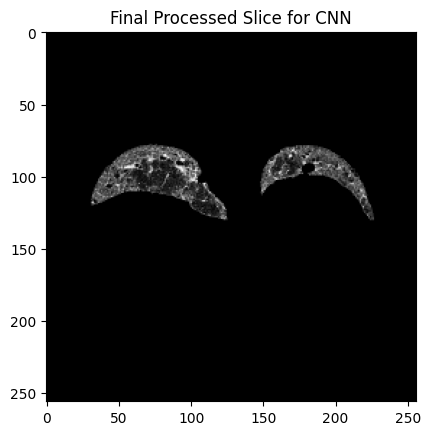

In [52]:
# 3.3 Apply the Functions and Visualize
print("--- Applying Slice Selection and Resizing ---")
# Use the 'segmented_lungs_hu' from the previous step
lower_55_lungs = select_lower_slices(segmented_lungs_hu)
print(f"Original shape: {segmented_lungs_hu.shape}, New shape after selection: {lower_55_lungs.shape}")

# Prepare the selected slices for the CNN
cnn_input = prepare_for_cnn(lower_55_lungs)
print(f"Final shape for CNN input: {cnn_input.shape}")

# Let's visualize one of the final processed slices to check
plt.imshow(cnn_input[cnn_input.shape[0] // 2, :, :, 0], cmap='gray')
plt.title('Final Processed Slice for CNN')
plt.show()